Get the masks from qupath by going to stardist github, they have link to .groovy script that you drag and drop into qupath to get the ground truth masks

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [2]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [3]:
#Read input image and corresponding mask names
X = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\tiles256\*.tif'))
Y = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons\qupath_pro\ground_truth\masks\*.tif'))

In [4]:
#Read images and masks using their names.
#We are using tifffile library to read images as we have tif images.
X = list(map(imread,X))
Y = list(map(imread,Y))

In [5]:
from PIL import Image

X_aug = [[] for _ in range(len(X))]
Y_aug = [[] for _ in range(len(Y))]

for i in range(len(X)):
    im = Image.fromarray(X[i])
    lbl = Image.fromarray(Y[i])
    for _ in range(3):
        im = im.rotate(90)
        X_aug[i].append(im)
        lbl = lbl.rotate(90)
        Y_aug[i].append(lbl)

    im = Image.fromarray(X[i])
    flipped_im = im.transpose(Image.FLIP_LEFT_RIGHT)

    lbl = Image.fromarray(Y[i])
    flipped_lbl = lbl.transpose(Image.FLIP_LEFT_RIGHT)

    X_aug[i].append(flipped_im)
    Y_aug[i].append(flipped_lbl)

    for _ in range(3):
        flipped_im = flipped_im.rotate(90)
        X_aug[i].append(flipped_im)
        flipped_lbl = flipped_lbl.rotate(90)
        Y_aug[i].append(flipped_lbl)

In [6]:
print(np.asarray(X_aug[0][0]).shape)

(256, 256, 3)


In [7]:
#Normalize input images and fill holes in masks
X = [x/255 for x in X]  # no norm, just divide by 255 to get into (0,1) range
Y = [fill_label_holes(y) for y in tqdm(Y)]  # fills holes in annotations if there are any

for i in range(len(X_aug)):
    ind = X_aug[i]
    for j in range(len(ind)):
        im = ind[j]
        im = np.asarray(im)
        im = im/255
        X_aug[i][j] = im

for i in range(len(Y_aug)):
    ind = Y_aug[i]
    for j in range(len(ind)):
        im = ind[j]
        im = np.asarray(im)
        im = fill_label_holes(im)
        Y_aug[i][j] = np.array(im)

100%|██████████| 7/7 [00:00<00:00, 175.00it/s]


In [8]:
print(X[0].shape)
print(X_aug[0][0].shape)

(256, 256, 3)
(256, 256, 3)


In [9]:
print(len(X_aug[0]))

7


In [10]:
X_val = []
X_trn = []
X_trn = X.copy()

Y_val = []
Y_trn = []
Y_trn = Y.copy()

for i in range(len(X_aug)):
    X_augs = X_aug[i]
    Y_augs = Y_aug[i]

    assert len(X_augs) > 1, "not enough training data"
    rng = np.random.RandomState(42)
    ind = rng.permutation(len(X_augs))
    n_val = max(1, int(round(0.15 * len(ind))))
    ind_trn, ind_val = ind[:-n_val], ind[-n_val:]

    for j in ind_val:
        X_val.append(X_augs[j])
        Y_val.append(Y_augs[j])

    for j in ind_trn:
        X_trn.append(X_augs[j])
        Y_trn.append(Y_augs[j])

print(f'number of images: {len(X)}')
print(f'- training: {len(X_trn)}')
print(f'- validation: {len(X_val)}')

X_trn = [np.array(x) for x in X_trn]
Y_trn = [np.array(y) for y in Y_trn]

X_val = [np.array(x) for x in X_val]
Y_val = [np.array(y) for y in Y_val]

number of images: 7
- training: 49
- validation: 7


In [11]:
print(X[0].shape)
print(X_aug[0][0].shape)
print(X_val[0].shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


(256, 256, 3)


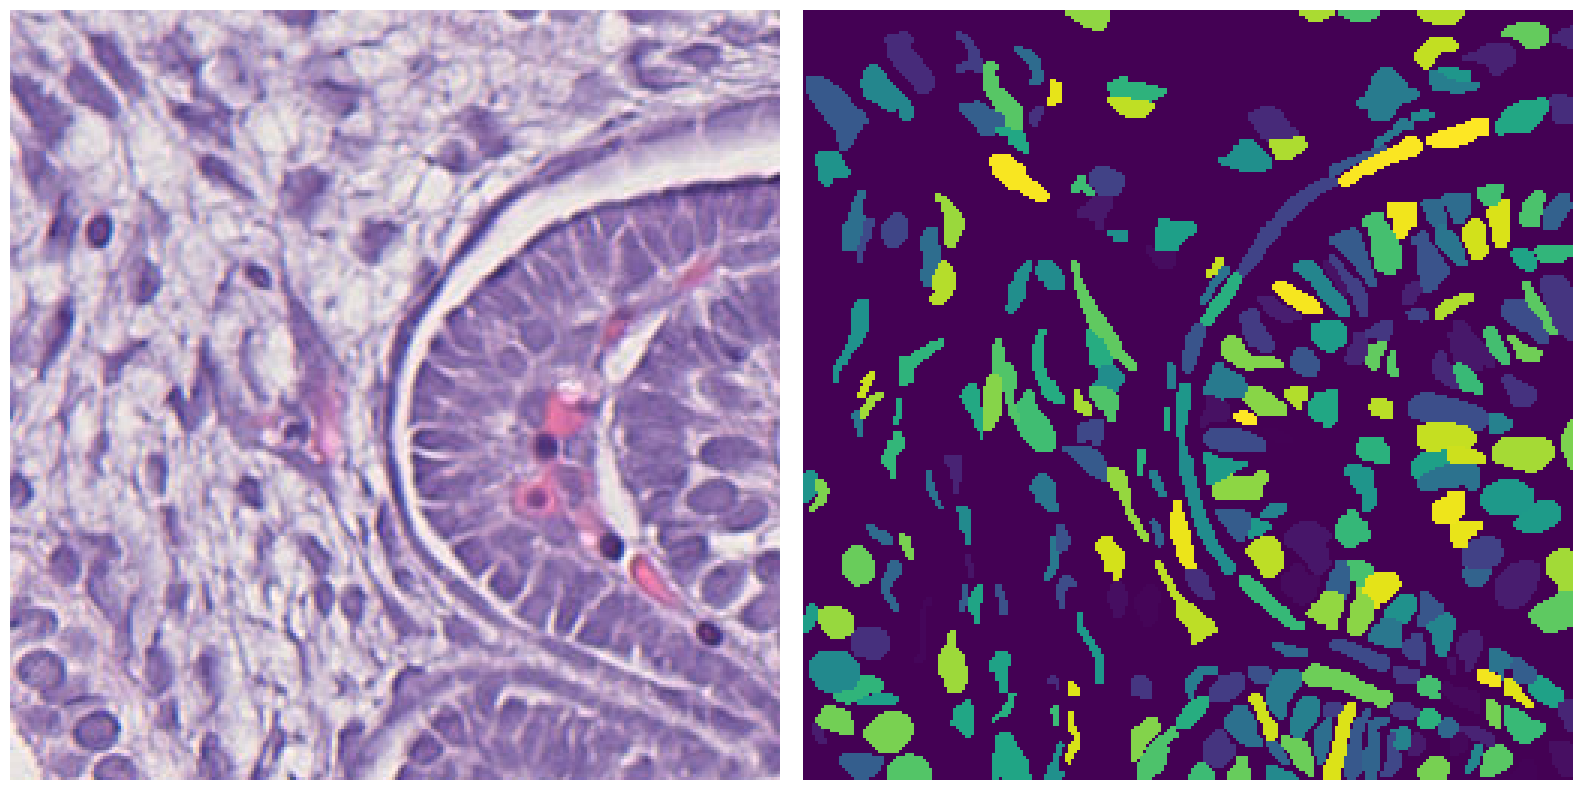

In [12]:
#PLot image and label for some images - sanity check
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


i = 6

img, lbl = X_val[i], Y_val[i]
print(img.shape)
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
show_tile_segmented(img,lbl)

In [13]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [14]:
tf.__version__

'2.9.3'

In [15]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.


conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_p

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [16]:
if use_gpu:
    print('Using gpu')
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

Using gpu


In [17]:
#Start from 40x H&E pre-trained model to the specified directory
import copy

def load_published_he_model(folder_to_write_new_model_folder: str, name_for_new_model: str) -> StarDist2D:
    published_model = StarDist2D.from_pretrained('2D_versatile_he')
    original_thresholds = copy.copy({'prob': published_model.thresholds[0], 'nms': published_model.thresholds[1]})
    configuration = Config2D(n_channel_in=3, grid=(2,2), use_gpu=True, train_patch_size=[256, 256])
    model = StarDist2D(config=configuration, basedir=folder_to_write_new_model_folder, name=name_for_new_model)
    model.keras_model.set_weights(published_model.keras_model.get_weights())
    model.thresholds = original_thresholds
    return model

pth_save = r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist'
nm = 'monkey_tile_trained_v3'
model = load_published_he_model(pth_save, nm)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [18]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [13. 11.]
network field of view :  [94 94]


In [19]:
print(len(X_trn))
print(len(Y_trn))
print(len(X_val))
print(len(Y_val))

49
49
7
7


In [20]:
model.config.train_learning_rate = 1e-6
model.config.train_patch_size = (256,256)
print(model.config)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=1e-06, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, u

In [21]:
# model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=10, steps_per_epoch=100, train_learning_rate=10e-6)
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), epochs=150, steps_per_epoch=100)

Epoch 1/150
Cause: Unable to locate the source code of <function _gcd_import at 0x0000021D379C1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000021D379C1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x0000021D379C1310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 6s 43ms/step - loss: 1.0908 - prob_loss: 0.5769 - dist_loss: 2.5692 - prob_kld: 0.3993 - dist_relevant_mae: 2.5687 - dist_relevant_mse: 18.9307 - dist_dist_iou_metric: 0.5213 - val_loss: 1.0671 - val_prob_loss: 0.5459 - val_dist_loss: 2.6059 - val_prob_kld: 0.3678 - val_dist_relevant_mae: 2.6054 - val_dist_relevant_mse: 19.8873 - val_dist_dist_iou_metric: 0.5150 - lr: 1.0000e-06
Epoch 2/150
100/100 [==============================

In [22]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:01<00:00, 10.20it/s, 0.600 -> 0.549]


Using optimized values: prob_thresh=0.581572, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5815724805825635, 'nms': 0.3}

In [23]:
model

StarDist2D(monkey_tile_trained_v3): YXC → YXC
├─ Directory: C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey_tile_trained_v3
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_ra

In [24]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 7/7 [00:00<00:00, 19.66it/s]


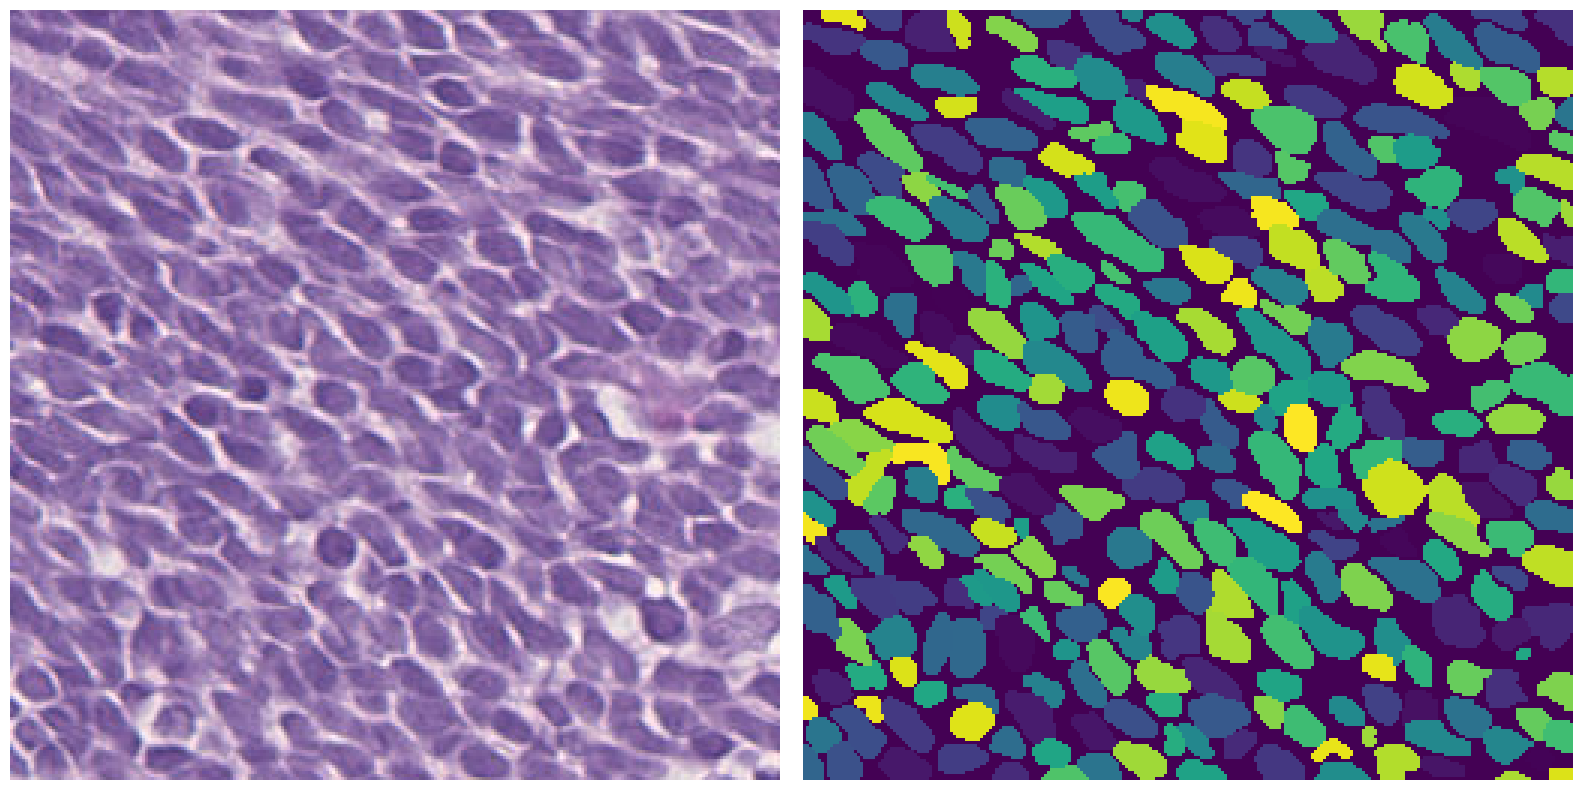

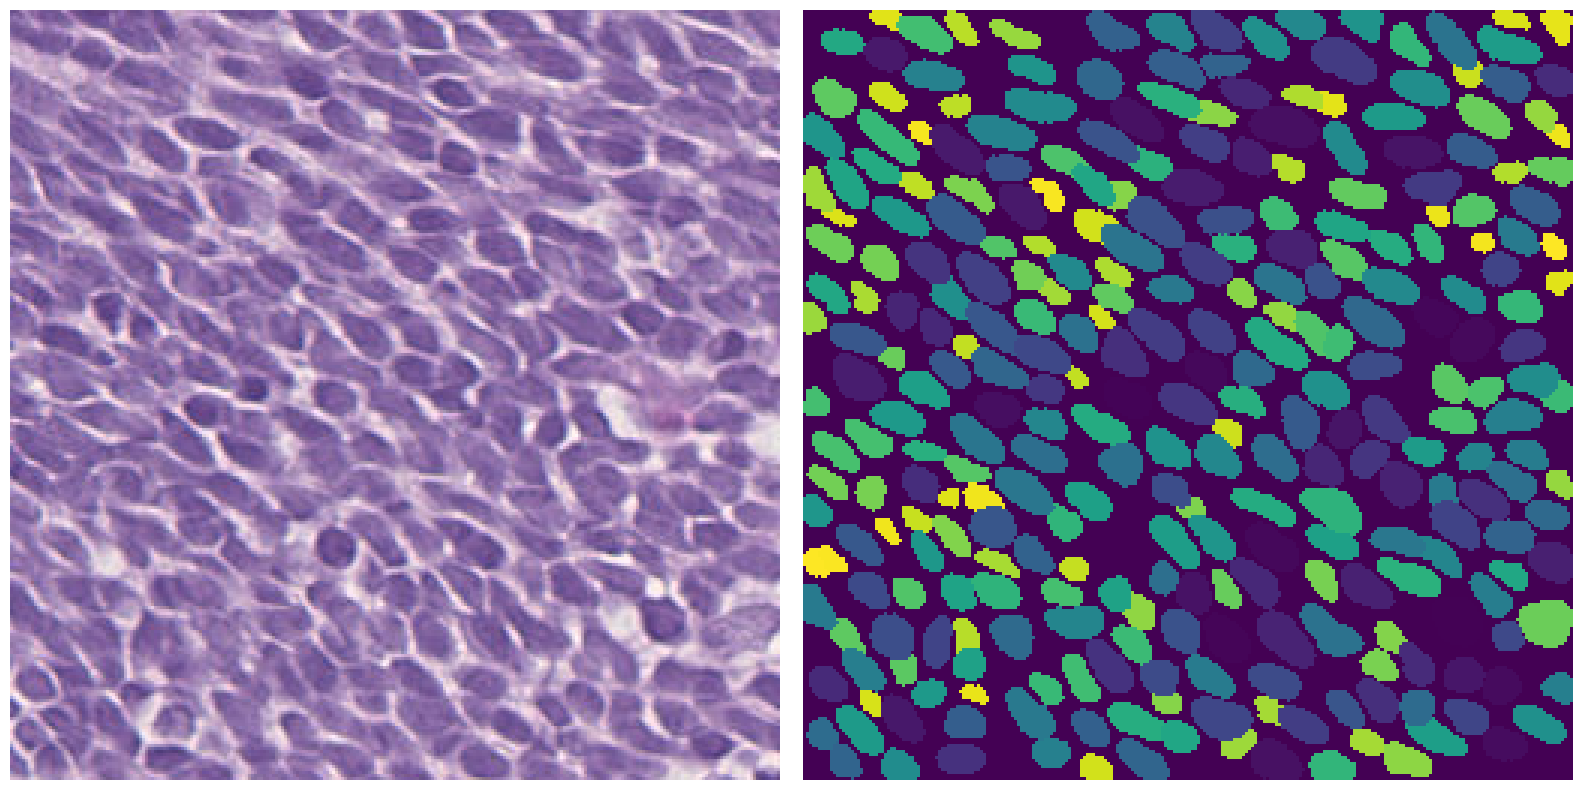

100%|██████████| 9/9 [00:00<00:00, 62.94it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=237, tp=1087, fn=459, precision=0.8209969788519638, recall=0.703104786545925, accuracy=0.60964666292765, f1=0.7574912891986063, n_true=1546, n_pred=1324, mean_true_score=0.5172730627220321, mean_matched_score=0.7356983946350154, panoptic_quality=0.5572851254134228, by_image=False)

In [25]:
#PLot original labels and predcitions
ind = 2

show_tile_segmented(X_val[ind],Y_val[ind])
show_tile_segmented(X_val[ind],Y_val_pred[ind])


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

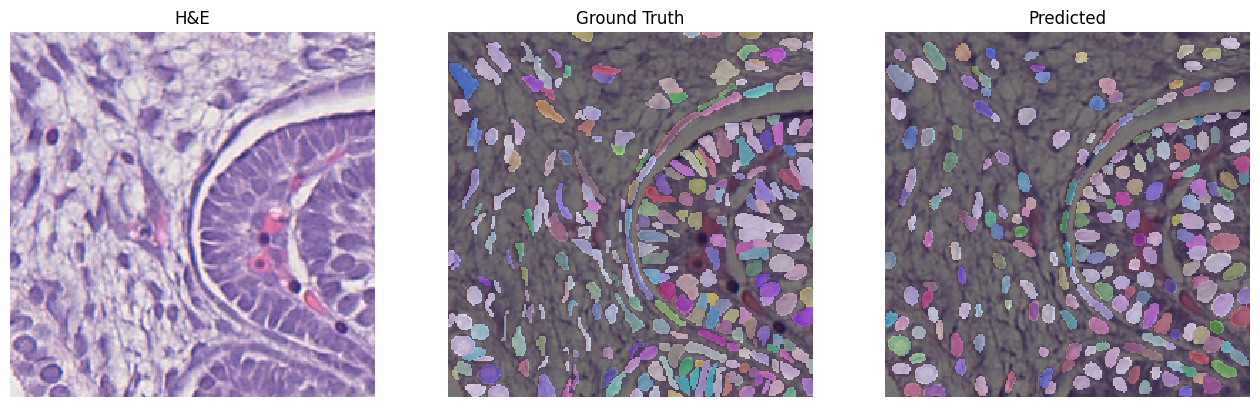

In [26]:
ind = 6

cropped_img = X_val[ind]
cropped_lbl = Y_val_pred[ind]
cropped_lbl_gt = Y_val[ind]

fig, ax = plt.subplots(1,3,figsize = (16, 8))
ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl_gt, cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(cropped_img)
ax[2].imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.5)
ax[2].axis('off')
ax[2].set_title('Predicted')
plt.show()

100%|██████████| 5/5 [00:00<00:00,  6.33it/s]


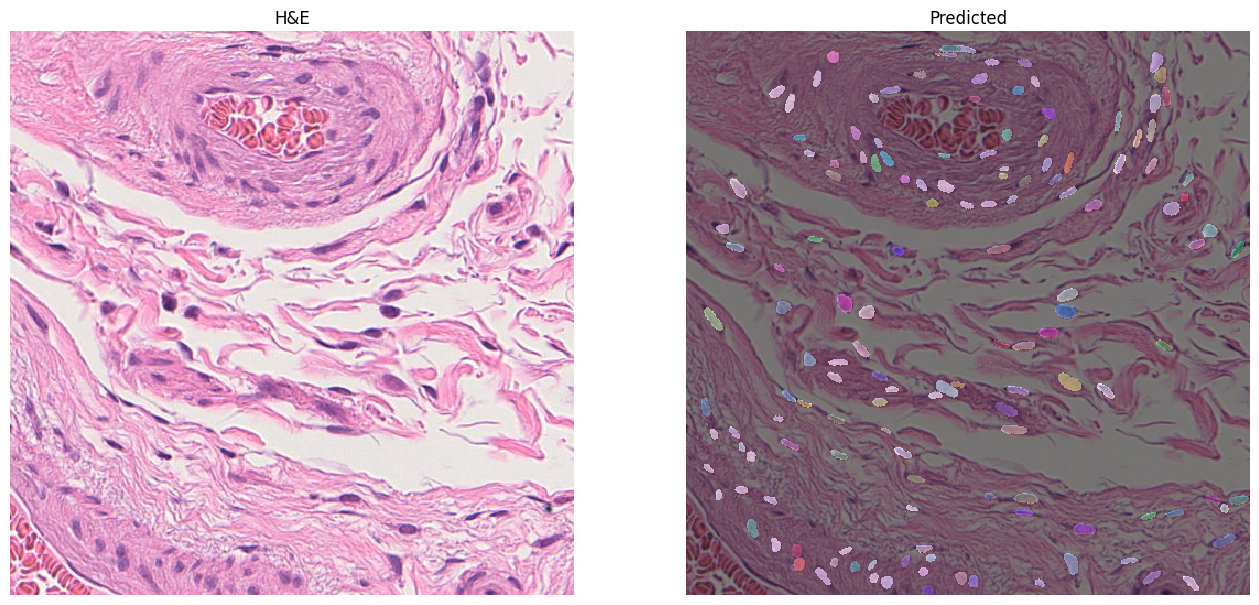

In [27]:
pth = r'C:\Users\Donald\Desktop\test_andre_fallopian_tube_stardist\tiles\*.tif'

X_andre = sorted(glob(pth))
X_andre = list(map(imread,X_andre))
X_andre = [x/255 for x in X_andre]  # no norm, just divide by 255 to get into (0,1) range

Y_pred_andre = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_andre)]

ind = 4

cropped_img = X_andre[ind]
cropped_lbl = Y_pred_andre[ind]

fig, ax = plt.subplots(1,2,figsize = (16, 8))
ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Predicted')
plt.show()